# Capacity Data Cleaning

This notebook works with:

- Planet Data

  * Reads raw Planet data
  * Removes duplicates from the data
  * Cleans the data by relabelling proper nans and adjusting the time dimension
  * Makes a CDF matching of data from period 1 using data from period 2 as a baseline

- ERA-5 Data

  * Reads raw ERA-5 data
  * Removes duplicates from the data
  * Cleans the data
  * Selects nearest neightbor for each pixel to match the grid of period 2
  * Makes a CDF matching of ERA-5 using data from period 2 as a baseline

After those steps:
  * Joins the three datasets along the time dimension
  * Stores the data as a NetCDF file


In [1]:
import sys
gp = '/home/jupyter-gabriel/'
sys.path.append(gp + "projects/suyana")
from scripts.utils.functions import *

In [3]:
def coarsen_data(ds, params_coarse):
    ds_new = ds.coarsen(params_coarse, boundary = 'pad').mean()
    return ds_new

In [4]:
def remove_duplicates(ds):
    ds_unique = ds.drop_duplicates(..., keep='first')

    return ds_unique


def clean_data(ds, date_range = (None, None), na_replace = None, time_dim = 'time', params_smooth = {'time':21}):
    # Remove duplicates
    if time_dim not in ds.dims:
        raise ValueError(f"Input for time_dim must be a subset of dimensions")
    ds = remove_duplicates(ds)
    
    # Convert time to datetime format
    ds[time_dim] = pd.to_datetime(ds[time_dim].values)
    
    # Create a week coordinate attached to the existing time dimension
    ds = ds.assign_coords(dict(
        week = (time_dim, ds[time_dim].dt.isocalendar().week.values)
    ))

    ds = ds.reindex(
        time=pd.date_range(
            start=ds[time_dim].min().values, end=ds[time_dim].max().values, freq="D"
        )
    )

    # Select data within the time window
    if date_range[0] is None and date_range[1] is None:
        pass
    else:
        ds = ds.sel(time = slice(date_range[0], date_range[1]))
    
    # Replace values with nan (65535 for Planet)
    if isinstance(na_replace, (int, float)):
        ds = ds.where(ds != na_replace, np.nan)

    # Apply a rolling mean to have a smooth time series by pixel

    ds = ds.rolling(params_smooth, min_periods = 1).mean()

    return ds

def summarize_data(ds, group_cols):
    
    if set(group_cols).issubset(set(list(ds.sizes.keys()))):
        # Average over all grouping columns (dimensions)
        ds = ds.mean(dim = group_cols)
    else:
        raise ValueError(f"Input for group_cols must be a subset of dimensions")
    return ds

In [5]:
def empirical_cdf_matching_grouped(df_fix, df_orig, field, group_cols):
    """
    Performs empirical CDF matching, handling NaN values.

    Args:
      x: The data to be adjusted.
      y: The reference data.

    Returns:
      The adjusted data.
    """
    df_base = df_orig[group_cols + [field]].copy()
    df_base['index'] = df_base.groupby(group_cols)[field].rank(method="first")
    df_base = df_base.dropna(subset=[field],axis=0)

    df_base_size = df_base.groupby(group_cols).agg(
        size=(field, 'count')
    ).reset_index()

    df_base = df_base.rename({field: field+'_adjusted'}, axis=1)
    
    df_fix['rank'] = (
        df_fix.groupby(group_cols)[field].rank(method="max")
        / df_fix.groupby(group_cols)[field].transform('count')
    )
    
    df_fix = df_fix.merge(
        df_base_size,
        how = 'left',
        on = group_cols
    )

    df_fix['index'] = np.floor(df_fix['rank']*df_fix['size'])
    
    df_fix = df_fix.merge(
        df_base[group_cols +['index', field+'_adjusted']],
        how = 'left',
        on = group_cols + ['index']
    ).drop(labels=['index', 'size', 'rank'], axis=1)

    return df_fix

def empirical_cdf_matching(df_fix, df_orig, field, group_cols = None):
    if group_cols is None:
        df_fix['aux__var'] = 1
        df_orig['aux__var'] = 1
        group_cols = ['aux__var']
        df_fix = empirical_cdf_matching_grouped(df_fix, df_orig, field, group_cols)
        df_fix.drop(group_cols, axis=1, inplace=True)
        df_orig.drop(group_cols, axis=1, inplace=True)
    else:
        df_fix = empirical_cdf_matching_grouped(df_fix, df_orig, field, group_cols)
    return df_fix

In [6]:
def cdf_matching_grouped(ds_period1, ds_period2, field, group_cols=None, time_dim = 'time', adjust_field_base = False):
    
    # Turn the xarrays into dataframes to apply the empirical_cdf_matching function
    df_fix = ds_period1.to_dataframe().reset_index()
    df_base = ds_period2.to_dataframe().reset_index()
    
    df_fix = empirical_cdf_matching(
        df_fix, df_base, field , group_cols
    )
    if adjust_field_base: 
        ds_period2[field+'_adjusted'] = ds_period2[field] 
    
    # Create an xarray Dataset
    dims = list(ds_period2.sizes.keys())
    coords = list(ds_period2.coords.keys())
    drop_vars = list(set(coords) - set(dims))

    df_fix.drop(['week'], axis=1, inplace=True)

    ds_period1 = df_fix.set_index(dims).to_xarray()
    
    #ds_period1 = ds_period1.set_coords(coords)
    #ds_period1 = ds_period1.drop_vars(drop_vars)
    
    ds_period1 = ds_period1.assign_coords(dict(
        week = (time_dim, ds_period1[time_dim].dt.isocalendar().week.values)
    ))
    return ds_period1, ds_period2


In [7]:
def scale_data_grouped(df_fix, df_orig, field, time_dim, group_cols=None):
    
    min_day = min(df_fix[time_dim].dt.dayofyear.values)
    max_day = max(df_fix[time_dim].dt.dayofyear.values)
    
    df_base = df_orig.loc[(df_orig[time_dim].dt.dayofyear >= min_day) & (df_orig[time_dim].dt.dayofyear <= max_day)].copy()

    df_base = df_base.groupby(group_cols).agg(
        mean_field = (field, 'mean'),
        std_field = (field, 'std'),
    ).reset_index()

    df_fix['local_mean'] = df_fix.groupby(group_cols)[field].transform('mean')
    df_fix['local_std'] = df_fix.groupby(group_cols)[field].transform('std')

    df_fix  = df_fix.merge(
        df_base,
        how = 'left',
        on = group_cols
    )

    df_fix[field + '_adjusted'] = ((df_fix[field] - df_fix['local_mean'])/df_fix['local_std']) *df_fix['std_field']  + df_fix['mean_field']
    
    df_fix = df_fix.drop(labels=['local_mean', 'local_std', 'std_field', 'mean_field'], axis=1)
    
    return df_fix

def scale_data(df_fix, df_orig, field, time_dim = 'time', group_cols = None):
    if group_cols is None:
        df_fix['aux__var'] = 1
        df_orig['aux__var'] = 1
        group_cols = ['aux__var']
        df_fix = scale_data_grouped(df_fix, df_orig, field, time_dim, group_cols)
        df_fix.drop(group_cols, axis=1, inplace=True)
        df_orig.drop(group_cols, axis=1, inplace=True)
    else:
        df_fix = scale_data_grouped(df_fix, df_orig, field, time_dim, group_cols)
    return df_fix

In [8]:
def scaling_grouped(ds_period1, ds_period2, field,  time_dim = 'time', group_cols=None, adjust_field_base = False):
    
    # Turn the xarrays into dataframes to apply the empirical_cdf_matching function
    df_fix = ds_period1.to_dataframe().reset_index()
    df_base = ds_period2.to_dataframe().reset_index()
    
    df_fix = scale_data(
        df_fix, df_base, field , time_dim, group_cols
    )
    if adjust_field_base: 
        ds_period2[field+'_adjusted'] = ds_period2[field] 
    
    # Create an xarray Dataset
    dims = list(ds_period2.sizes.keys())
    coords = list(ds_period2.coords.keys())
    drop_vars = list(set(coords) - set(dims))
    #df_fix = df_fix.drop(['week'], axis=1)
    ds_period1 = df_fix.set_index(dims).to_xarray()
    
    ds_period1 = ds_period1.set_coords(coords)
    #ds_period1 = ds_period1.drop_vars(drop_vars)
    #ds_period1 = ds_period1.assign_coords(dict(
    #    week = (time_dim, ds_period1[time_dim].dt.isocalendar().week.values)
    #))

    return ds_period1, ds_period2


In [9]:
def create_window_w_data(ds_orig, ds_base, date_range = (None, None)):
    
    # Select data within the time window
    if date_range[0] is None and date_range[1] is None:
        ds_fill = ds_orig
    else:
        ds_fill = ds_orig.sel(time = slice(date_range[0], date_range[1]))

    # Select the nearest neighbors from the grid pixels on ds_base
    ds_fill = ds_fill.sel(
        lat = ds_base.lat, lon = ds_base.lon, method = 'nearest'
    )
    ds_fill = ds_fill.assign_coords(
        lat = ds_base.lat, 
        lon = ds_base.lon, 
        time = ds_fill.time.dt.round('d'),
        week = ('time', ds_fill.time.dt.isocalendar().week.values)
    )

    return ds_fill

In [10]:
def concat_arrays(ds_ini, dim_along = None, *ds_arrays):
    if set([dim_along]).issubset(set(list(ds_ini.sizes.keys()))):
        # Create a list of all datasets to concatenate
        all_ds = [ds_ini] + list(ds_arrays)
        
        # Perform concatenation
        ds_final = xr.concat(all_ds, dim=dim_along)
    else:
        raise ValueError(f"Input for dim_along must be a subset of dimensions")
    
    # Sort and rename as needed
    if dim_along in ds_final.dims:
        ds_final = ds_final.sortby(dim_along)
        
    return ds_final

In [11]:
ds_period1 = xr.open_dataset(gp + 'suyana/drought/swc/raw/canton_43/canton_43_1.nc')
ds_period2 = xr.open_dataset(gp + 'suyana/drought/swc/raw/canton_43/canton_43_2.nc')
ds_era = xr.open_dataset(gp + 'projects/suyana/data/capacity/soilwater.nc')

In [55]:
date_ini = max((ds_period1.time + np.timedelta64(1, "D")).dt.date.astype(str).values)
date_fin = min((ds_period2.time - np.timedelta64(1, "D")).dt.date.astype(str).values)

In [56]:
ds_period1 = clean_data(ds_period1, date_range=(None, date_ini), na_replace=65535, params_smooth = {'time':21})
ds_period2 = clean_data(ds_period2, date_range=(date_fin, '2024-10-31'), na_replace=65535, params_smooth = {'time':21})


In [57]:
ds_period1 = coarsen_data(ds_period1, params_coarse={'lon':3, 'lat':3})
ds_period2 = coarsen_data(ds_period2, params_coarse={'lon':3, 'lat':3})

In [58]:
ds_empty = create_window_w_data(ds_era, ds_period2, date_range=(date_ini, date_fin))

In [59]:
ds_empty = clean_data(ds_empty, date_range=(date_ini, date_fin), params_smooth={'time':3})

In [32]:
'''
ds_period1 = summarize_data(ds_period1, group_cols=['lon', 'lat'])
ds_period2 = summarize_data(ds_period2, group_cols=['lon', 'lat'])
ds_empty = summarize_data(ds_empty, group_cols=['lon', 'lat'])
'''

In [60]:
ds_period1, ds_period2 = cdf_matching_grouped(ds_period1, ds_period2, 'swc', group_cols=['lon', 'lat', 'week'], adjust_field_base=True)

In [61]:
ds_empty, ds_period2 = cdf_matching_grouped(ds_empty, ds_period2, 'swc')

In [62]:
ds_concat = concat_arrays(ds_period1, 'time', ds_empty, ds_period2)

# Create clean datasets from raw datasets from Planet and ERA-5

In [12]:
# Read the yields panel dataset to clean only the required values of canton
df_yields_final = pd.read_csv(gp+'projects/suyana/data/drought/yields_panel_id.csv')

In [13]:
import os
path = gp+"/suyana/drought/swc/raw/"
files = os.listdir(path)
files = [f for f in files if f.startswith("canton")]
id_canton = [files[i].split("_")[1] for i in range(len(files))]

list_ids = sorted(list(set(df_yields_final['id_canton'].astype(str)).intersection(set(id_canton))))
list_ids

['189', '195', '209', '43', '49', '52', '54', '56', '57']

In [14]:
ds_era = xr.open_dataset(gp + 'projects/suyana/data/capacity/soilwater.nc')
ds_era = ds_era.rolling(time = 14, min_periods=1).mean()

In [15]:
for id in list_ids:
    print(f"Canton: {id}")
    local_path = path + 'canton_' + str(id) + '/'
    files = sorted(os.listdir(local_path))
    for i in range(len(files)):
        if i==0:
            ds_period1 = xr.open_dataset(local_path + files[i])
        if i > 0:
            ds_period2 = xr.open_dataset(local_path + files[i])
            #netcdf_ini = xr.concat([netcdf_ini, netcdf_aux], dim='time')

    #Obtener bordes de la ventana temporal
    date_ini = max((ds_period1.time + np.timedelta64(1, "D")).dt.date.astype(str).values)
    date_fin = min((ds_period2.time - np.timedelta64(1, "D")).dt.date.astype(str).values)

    ds_period1 = clean_data(ds_period1, date_range=(None, date_ini), na_replace=65535, params_smooth = {'time':21})
    ds_period2 = clean_data(ds_period2, date_range=(date_fin, '2024-10-31'), na_replace=65535, params_smooth = {'time':21})
    
    ds_period1 = coarsen_data(ds_period1, params_coarse={'lon':3, 'lat':3})
    ds_period2 = coarsen_data(ds_period2, params_coarse={'lon':3, 'lat':3})
    
    ds_empty = create_window_w_data(ds_era, ds_period2, date_range=(date_ini, date_fin))
    

    ds_empty = clean_data(ds_empty, date_range=(date_ini, date_fin), params_smooth={'time':1})
    print(f"Cleaning done")

    ds_period1, ds_period2 = cdf_matching_grouped(ds_period1, ds_period2, 'swc', group_cols=['lon', 'lat', 'week'], adjust_field_base=True)
    ds_empty, ds_period2 = cdf_matching_grouped(ds_empty, ds_period2, 'swc')
    print(f"CDF matching done")
    
    ds_concat = concat_arrays(ds_period1, 'time', ds_empty, ds_period2)
    print(f"Filling empty window done and concatenating arrays")


    comp = dict(zlib=True, complevel=9)
    encoding = {var: comp for var in ds_concat.data_vars}
    
    ds_concat.to_netcdf(
        gp + '/projects/suyana/data/capacity/canton_processed_' + str(id) +'.nc',
        encoding = encoding
    )

Canton: 189
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 195
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 209
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 43
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 49
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 52
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 54
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 56
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays
Canton: 57
Cleaning done
CDF matching done
Filling empty window done and concatenating arrays


In [16]:
ds_concat.sizes

Frozen({'time': 8175, 'lat': 14, 'lon': 20})

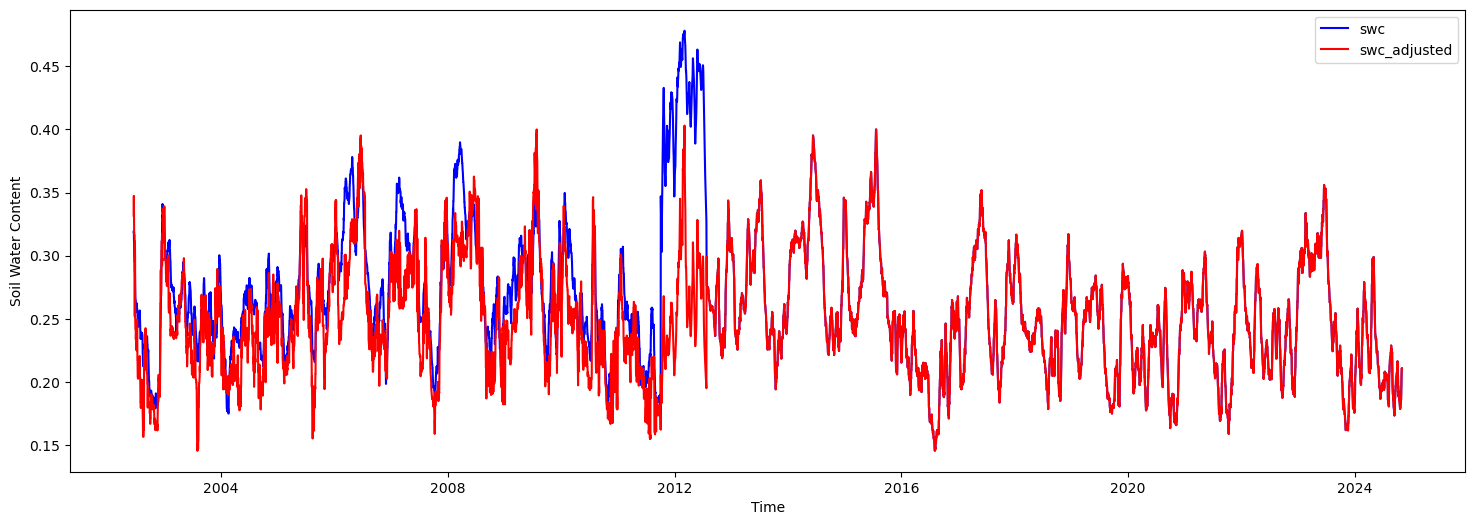

In [17]:
# Select the data at the specific location 
ds_location = ds_concat.isel(lon=0, lat=13)
#ds_location = ds_location.sel(time=slice('2010-10-01', '2013-07-31'))
# Plotting 
plt.figure(figsize=(18, 6)) 
plt.plot(ds_location.time, ds_location.swc, label='swc', color='blue') 
plt.plot(ds_location.time, ds_location.swc_adjusted, label='swc_adjusted', color='red') 
plt.xlabel('Time') 
plt.ylabel('Soil Water Content')
plt.legend()
plt.show()

In [18]:
climatology = ds_concat.groupby('time.dayofyear').mean(dim = ['time', 'lon', 'lat'])
ds_climatology = xr.DataArray(
    climatology['swc_adjusted'].sel(dayofyear=ds_concat['time.dayofyear']), dims = ['time']
)

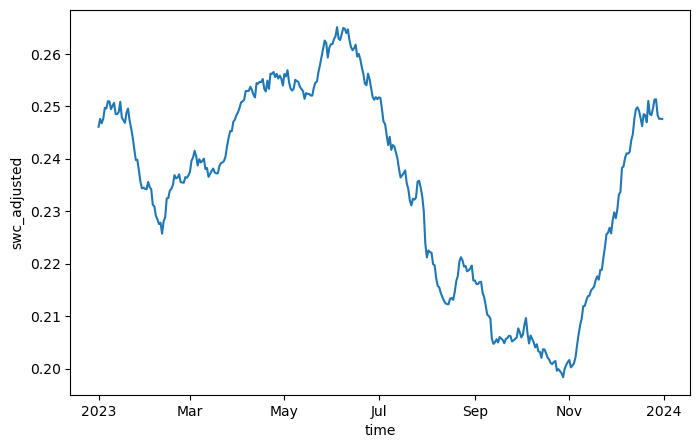

In [19]:
# Plotting 
ds_climatology = ds_climatology.sel(time=slice('2023-01-01', '2023-12-31'))
plt.figure(figsize=(8, 5)) 
ds_climatology.plot()